# Example OpenTISim with OpenCLSim for Export - Import Terminal 

In this notebook, an example is demonstrated showing the linkage of OpenTISim and OpenCLSim. 

- OpenTISim is a terminal investment module, it calculates how many terminal elements are needed on a given terminal to meet a given demand. 
- OpenCLSim is a complex simulation module, in which the transport between two points can be simulated.

In this notebook an entire supply chain is modeled by calculating how many elements are needed at all terminals with OpenTISim and by calculating how many ships are needed between terminals to ship everything with OpenCLSim. This notebook looks at a liquid bulk supply chain from the export terminal to the import terminal with vessel transport between the two terminals. 

## The specific supply chain

This example looks at supply chains that can occur when large quantities of hydrogen need to be shipped. Hydrogen is a gas and therefore has a low energy density. In order to transport more energy in a ship, the hydrogen must therefore be liquefied or it can be compressed or attached to a so-called hydrogen carrier. This research looks at 4 different types of forms: 

- Liquify the hydrogen: Liquid Hydrogen ($LH_2$)
- Attach to a carrier: Ammonia ($NH_3$)
- Attach to a carrier: Liquid Organic Hydrogen Carrier: $MCH$
- Attach to a carrier: Liquid Organic Hydrogen Carrier: $DBT$ 

Thus, at the export terminal the hydrogen must be liquefied or attached to a carrier and at the import terminal it must be reconverted. As a result, plants will be needed at the export terminal and import terminal to fulfill these conversion processes. The elements present at the terminals in OpenTISim then consist of:

- Export Terminal: Conversion plants, Storage tanks, Pipeline to jetty, Jetty
- Import Terminal, Reconversion plants, Storage tanks, Pipeline to jetty, Jetty

## 0. Import packages and initialise objects

### Import packages

First, all packages must be imported to allow OpenTISim and OpenCLSim to be used. 

In [1]:
### import datetime, time
import numpy as np
import numpy.matlib as npml
import pandas as pd
import statistics as st
from copy import deepcopy

import networkx as nx
import simpy

import matplotlib.pyplot as plt
from simplekml import Kml, Style   # for graph_kml
import math

import shapely.geometry
import pyproj

import pandas as pd
from opentisim.liquidbulk.hydrogen_defaults import *
from opentisim.liquidbulk.hydrogen_objects import *
import opentisim

# OpenCLSim
import openclsim
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

### Initialise Supply Chains, Objects and Transport modes

First, create a class for the supply chain and define what OpenCLSim should include in the definition of a location, a transport process and the so-called boiloff process. The boiloff process represents the loss during transport. For example, when transporting liquid hydrogen, loss of cargo occurs during transport due to evaporation. 

#### Create Supply Chain 

In [2]:
class SupplyChain:
    """This class implements a 'supply chain'.
    - name: supplychain name
    - origin: geometry indicating the origin
    - destination: geometry indicating the destination
    - elements: list of objects that can be used to transport goods (vessels, trucks, etc)
    - modal split: indicating a split
    """

    def __init__(self, 
                 name='Supply chain',
                 elements=[],
                 origin='from_site',
                 origin_latent_demand = 0,
                 origin_online_throughput = 0,
                 destination='mid_site',
                 destination_latent_demand = 0,
                 destination_online_throughput = 0,
                 capacity=None,
                 condition=[],
                 modalsplit=None
                 ):
        # identity
        self.name = name

        # collection of all terminal objects
        self.elements = elements

         # time inputs
        self.origin = origin
        self.origin_latent_demand = origin_latent_demand
        self.origin_online_throughput = origin_online_throughput
        self.destination = destination
        self.destination_latent_demand = destination_latent_demand
        self.destination_online_throughput = destination_online_throughput
        self.capacity = capacity
        self.condition = condition
        self.modalsplit = modalsplit

#### Create Site, Transport and Boil-off objects 

In [3]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.Locatable,
        openclsim.core.HasContainer,
        openclsim.core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.ContainerDependentMovable,
        openclsim.core.Processor,
        openclsim.core.HasResource,
        openclsim.core.LoadingFunction,
        openclsim.core.UnloadingFunction,
    ),
    {},
)

# create a BoiloffResource object based on desired mixin classes
BoiloffResource = type(
    "Boil-off",
    (
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.ContainerDependentMovable,
        #openclsim.core.Processor,
        openclsim.core.HasResource,
        #openclsim.core.LoadingFunction,
        #openclsim.core.UnloadingFunction,
    ),
    {},
)

## 1. Initiate Simulation

Now it is time to initiate the simulation. Below the steps for the initiation are described shortly:

* Step 1.1: Prepare Model set-up
    * Step 1.1.1.: Define the supply chain
    * Step 1.1.2.: Find distance 
    * Step 1.1.3.: Prepare graph 
    * Step 1.1.4.: Find values shipping route 
* Step 1.2: Add properties to the graph
    * Step 1.2.1: Assign throughput scenarios to nodes
    * Step 1.2.2: Assign OpenTISim terminal elements to nodes
    * Step 1.2.3: Identify active supply chains

### 1.1 Prepare Model set-up

#### 1.1.1. Define the supply chain 

As described above this notebook examines a supply chain regarding the transport of hydrogen. First of all the specific supply chain that will be examined must be defined. In this supply chain specification you can vary with: 

- The kind of hydrogen transport form: liquid hydrogen, ammonia, MCH, DBT [carrier]
- The place of the reconversion plant: centralized, decentralized [place]

Furthermore, one needs to define some input values:
- the year in which the project will start [startyear]
- the period of the model [lifecycle]
- the demand of hydrogen at the import terminal [demand_hydrogen]

In [4]:
#define supply chain and input parameters 
startyear = 2020
lifecycle = 10 
carrier = 'liquid hydrogen' # ammonia, MCH, DBT
place = 'centralized' # decentralized 
transport_sc1 = 'vessel'
demand_hydrogen = 2_000_000

#define array of modellife 
years = list(range(startyear, startyear+lifecycle))

#define structure of supply chain
if place == 'decentralized':
    sc_export = {'berth_jetty','pipeline_jetty_-_terminal', 'storage', 'h2_conversion'}
    sc_import = {'berth_jetty','pipeline_jetty_-_terminal', 'storage'}
if place == 'centralized':
    sc_export = {'berth_jetty','pipeline_jetty_-_terminal', 'storage', 'h2_conversion'}
    sc_import = {'berth_jetty','pipeline_jetty_-_terminal', 'storage', 'h2_retrieval'}

#load all the default values of the carriers 
if carrier == 'liquid hydrogen':
    commodity_type_defaults = commodity_lhydrogen_data
    storage_type_defaults = storage_lh2_data
    h2conversion_type_defaults = h2conversion_lh2_data
    h2retrieval_type_defaults = h2retrieval_lh2_data
    vessel_defaults = largehydrogen_data
        
if carrier == 'ammonia':
    commodity_type_defaults = commodity_ammonia_data
    storage_type_defaults = storage_nh3_data
    h2conversion_type_defaults = h2conversion_nh3_data
    h2retrieval_type_defaults = h2retrieval_nh3_data
    vessel_defaults = largeammonia_data

if carrier == 'MCH':
    commodity_type_defaults = commodity_MCH_data
    storage_type_defaults = storage_MCH_data
    h2conversion_type_defaults = h2conversion_MCH_data
    h2retrieval_type_defaults = h2retrieval_MCH_data
    vessel_defaults = vlcc_data

#### 1.1.2. Find distance 

First the distance must be calculated between the origin and destination. OpenCLSim uses the Dijkstra path function to calculate the distance between two points. However, this is not correct for a sailing route, because the Dijkstra path is the shortest path between two points, an international sailing route will however always be longer than this path because it will not be a straightline between the two points. That is why the distance is manually defined in this notebook. 

As an example for this notebook we are going to look at the Port of Rotterdam as the import terminal and the Port of Sohar (Oman) as the export terminal. The distance of this sailing route will be approximately 10,900 km. With the function 'find_coordinates(lat_start, lon_start, distance)' the coordinates are calculated of a point that is 10,900 km away from Rotterdam (this will not be the coordinates of Oman because of the Dijkstra path as discussed above). 

In [5]:
#starting point = Botlek, Rotterdam  (4.268813386454553,51.88121982094231)
#distance Rotterdam to Sohar = 10,900 km 

lat_start =  51.88121982094231 #latitude import
lon_start = 4.268813386454553 #longitude import  

distance = 10900 

londeg, latdeg = opentisim.core.find_coordinates(lat_start, lon_start, distance)

#coordinates of a point that is 10,900 km from Rotterdam 
print(londeg, latdeg)

172.87683558375178 29.47966746525635


#### 1.1.3. Prepare graph 

A graph can be made of the two nodes and the sailing route. However, because the dijkstra path is used this graph is not correct right now. This part should be extended in such a way that not the dijkstra path is used to find the sailingroute, but a network of sailingroutes should be used. In this way it is possible to make a graph of the two coordinates with the sailing route and the correct distance. 

NodeView(('from_site', 'mid_site'))

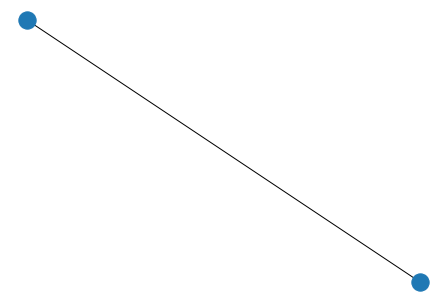

In [6]:
#convert the path to a networkx graph 
path = [(londeg, latdeg), # 1000 km 
        (4.268813386454553,51.88121982094231)] # Botlek NL 

# convert clicked path to networkx graph and draw
FG, positions, names = opentisim.core.convert_path_to_graph(path)
nx.draw(FG, positions)
FG.nodes

#name origin location and destination location
origin = shapely.geometry.Point(londeg, latdeg)
destination = shapely.geometry.Point(4.268813386454553,51.88121982094231)

# inspect graph on Google Earth
# graph_kml(
#     FG,
#     fname="supplychain.kml")

# Using 'path' the graph's nodes are automatically named: 'node-0', 'node-1', 'node-2', etc. Lets rename:

# prepare mapping
mapping = {
    'node-0':'from_site',  # from node
    'node-1':'mid_site',  # mid node 
          }

# apply mapping to graph object
FG = nx.relabel_nodes(FG, mapping)
FG.nodes

#### 1.1.4 Find values of the shipping route 

It is also needed to find some values with regards to the sailing route. The function below ('character_shippingroute') needs the origin and destination as input and returns:
- Distance (in km)
- Trip duration (in days) 
- Maximum that one vessel can carry in 1 year (in ton carrier) 
- Loss of load (in %)
- Loss of load (in ton carrier) 
- Number of trips of 1 vessel in 1 year 

In [7]:
def character_shippingroute(origin, destination, vessel_defaults):    
    #define the vessel defaults 
    capacity_ship = vessel_defaults["call_size"]
    pump_ship = vessel_defaults["pump_capacity"]
    loadingtime_ship = ((vessel_defaults["call_size"]/vessel_defaults["pump_capacity"]) +vessel_defaults["mooring_time"])*60*60
    unloadingtime_ship = ((vessel_defaults["call_size"]/vessel_defaults["pump_capacity"]) +vessel_defaults["mooring_time"])*60*60
    velocity_ship = vessel_defaults['avspeed']/3.6 # #25 km/h --> m/s 
    losses_ship = vessel_defaults['losses']
    
    #define the distance between the origin and destination 
    wgs84 = pyproj.Geod(ellps="WGS84")
    orig = shapely.geometry.asShape(origin)
    dest = shapely.geometry.asShape(destination)
    _, _, distance = wgs84.inv(orig.x, orig.y, dest.x, dest.y) #distance in m 
    distancekm = distance/1000 #distance in km 
    
    #define the ship velocity 
    v = lambda x: velocity_ship #default: ship velocity in m/s 
    current_speed = v 
    
    #define the loading and unloading time 
    loading = loadingtime_ship  #default: ship loading time in seconds  
    unloading = unloadingtime_ship #default: ship unloading time
    
    #define the ship capacity 
    capacity_ship = capacity_ship  #default: ship capacity in ton carrier 
    
    #define the duration of 1 trip 
    secyear = 60*60*24*365
    engine_order = 1 
    duration = distance/((current_speed) (engine_order)) # in seconds  
    durationdays = duration/60/60/24 # in days 

    #define the number of trips that a vessel can make in a year 
    onetriptime = loading + duration + unloading + duration 
    numberoftrips = math.ceil(secyear / onetriptime)
    
    #define the maximum that a ship can transport in 1 year 
    maxtrans1 = numberoftrips * capacity_ship 
    
    #define the boil off losses 
    bog = losses_ship #%/d default
    ton = capacity_ship #ton LH2 default 
    days = math.ceil(durationdays) #math.ceil math.floor
    bogtot = np.zeros(days)
    bogtot[0] = ton*(100-bog)/100
    for i in range(days-1):
        bogtot[i+1] = bogtot[i] - ((bog*bogtot[i])/100) 
        
    totloss = 100-((100*bogtot[-1])/ton)
    transloss = totloss # loss in percentage 
    lossofload = ton - ((100-transloss)*ton/100) # loss of ton carrier per trip 

    return distancekm, durationdays, maxtrans1, transloss, lossofload,numberoftrips

In [8]:
distancekm, durationdays, maxtrans1, transloss, lossofload,numberoftrips = character_shippingroute(origin, destination, vessel_defaults)

print('distance origin to destination is', distancekm, 'km')
print('duration of 1 trip is', durationdays, 'days')
print('1 ship can transfer a maximum of', maxtrans1, 'ton of', carrier, 'in 1 year')
print('1 ship has a transport loss of', transloss, '%, which is equal to', lossofload, 'ton of', carrier, 'per trip')
print('the number of trips is', numberoftrips)

distance origin to destination is 10923.106789860023 km
duration of 1 trip is 18.20517798310004 days
1 ship can transfer a maximum of 188860 ton of liquid hydrogen in 1 year
1 ship has a transport loss of 5.548685184993445 %, which is equal to 1047.9246840378619 ton of liquid hydrogen per trip
the number of trips is 10


### 1.2 Add properties to the graph
#### 1.2.1 Assign throughput scenarios to nodes

There is a terminal on each node, hence there will be a throughput at the nodes. That is why it is needed to assign a througput to each node. Below the throughput at each node will be defined. 

##### 1.2.1.1. Give nodes attribute for throughput

In [9]:
nx.set_node_attributes(FG, [], 'througput')

##### 1.2.1.2. Calculate the Supply and Demand

A specific demand is needed out of the import terminal, this demand is already defined above at the first step. In this example the demand is set at 2 Mton H2. As explained above the hydrogen will be converted to a liquid (liquid hydrogen, ammonia, MCH or DBT) to increase the energy density. Each type of transport form has it's own specific hydrogen content, e.g.  2 Mton H2 is equal to 11,33 Mton NH3. So the demand given in H2 needs to be converted to the chosen carrier. The given demand is the demand that is needed out of the import terminal. It also needs to be calculated how big the supply should be then to meet this demand, taking into account all the losses over the specified supply chain. 

##### Define all the losses that occur at each element and define the hydrogen content 

In [10]:
#losses
jetty_loss = jetty_pipeline_data['losses']
recplant_loss = h2retrieval_type_defaults['losses']
conplant_loss = h2conversion_type_defaults['losses']
storage_loss = storage_type_defaults['losses']*30
transport_loss = transloss 

#hydrogen content 
Hcontent = commodity_type_defaults['Hcontent']

##### Find the demand and the supply of the chosen carrier 

The supply depends on the losses of the elements that are present in the supply chain. Hence, the supply differs for a centralized and decentralized supply chain. With the given demand, structure of the supply chain and losses the supply at the export terminal can be calculated. 

In [11]:
#place of plant is decentralized 
if place == 'decentralized':
    demand_carrier1 = (demand_hydrogen * 100) / Hcontent #demand is converted to carrier 

    #import terminal is dimensioned on this demand plus losses (import terminal out)
    demand_import_out = demand_carrier1
    demand_import_in = (((jetty_loss+storage_loss)+100)*demand_carrier1)/100

    #export terminal is dimensioned on this demand plus losses (export terminal out)
    demand_export_out = (((transloss+jetty_loss+storage_loss)+100)*demand_carrier1)/100
    demand_export_in = (((conplant_loss + storage_loss + jetty_loss + transloss+jetty_loss+storage_loss)+100)*demand_carrier1)/100

#place of plant is centralized 
if place == 'centralized':
    demand_carrier1 = (demand_hydrogen * 100) / Hcontent #demand is converted to carrier 

    #import terminal is dimensioned on this demand plus losses (import terminal out)
    demand_import_out = demand_carrier1
    demand_import_in = (((jetty_loss+storage_loss+ recplant_loss )+100)*demand_carrier1)/100

    #export terminal is dimensioned on this demand plus losses (export terminal out)
    demand_export_out = (((transloss+jetty_loss+storage_loss + recplant_loss)+100)*demand_carrier1)/100
    demand_export_in = (((conplant_loss + storage_loss + jetty_loss + transloss+jetty_loss+storage_loss + recplant_loss)+100)*demand_carrier1)/100

    #print(demand_enduse_out)
    #print(demand_export_in )
print(demand_hydrogen, 'initial given demand in ton of hydrogen')     
print(demand_carrier1, 'initial given demand in ton of carrier') 
print(demand_import_out, 'demand in ton of carrier that needs the go out of the import terminal')
print(demand_import_in, 'demand in ton of carrier that needs the go in of the import terminal')
print(demand_export_in, 'demand in ton of carrier that needs the go in of the export terminal')
print(demand_export_out, 'demand in ton of carrier that needs the go out of the export terminal')

2000000 initial given demand in ton of hydrogen
2000000.0 initial given demand in ton of carrier
2000000.0 demand in ton of carrier that needs the go out of the import terminal
2036000.0 demand in ton of carrier that needs the go in of the import terminal
2182973.703699869 demand in ton of carrier that needs the go in of the export terminal
2146973.703699869 demand in ton of carrier that needs the go out of the export terminal


##### 1.2.1.3. Add a supply throughput at the Export Terminal 

Create and add a supply throughput at the Export Terminal. The export terminal is defined as the 'from _site'.
The export terminal is dimensioned on the demand that has to go in to the vessel, so the demand that has to go out of the export terminal (demand_export_out). In this code it is also possible to set a fluctuating supply over the years. 

In [12]:
# create a supply at the from_site
supply = []

#define the supply, it can also be fluctuating over the years
for year in years:
    if year < 2025:
        supply.append(demand_export_out) #(2_000_000 H2)
    else:
        supply.append(demand_export_out) #(4_000_000 H2)
        
throughput_from = pd.DataFrame({'year': years, 
                     'volume': supply})

#print the supply at the export terminal over the years
FG.nodes['from_site']['througput'] = throughput_from
display(throughput_from)

,year,volume
0,2020,2.146974e+06
1,2021,2.146974e+06
2,2022,2.146974e+06
3,2023,2.146974e+06
4,2024,2.146974e+06
5,2025,2.146974e+06
6,2026,2.146974e+06
7,2027,2.146974e+06
8,2028,2.146974e+06
9,2029,2.146974e+06


##### 1.2.1.4. Add a demand throughput at the Import Terminal 

Create and add a demand throughput at the Import Terminal. The import terminal is defined as the 'mid _site'.
The import terminal is dimensioned on the demand that has to go out of the terminal (demand_import_out). In this code it is also possible to set a fluctuating demand over the years. 

In [13]:
# create a demand at the mid_site
# demand = list(npml.repmat(2_000_000,1,len(years))[0])

demand = []
for year in years:
    if year < 2025:
        demand.append(demand_import_out) #(2_000_000 H2)
    else:
        demand.append(demand_import_out) #(4_000_000 H2)
        
#demand = list(npml.repmat(20_000_000,1,len(years))[0])
throughput_mid = pd.DataFrame({'year': years, 
                     'volume': demand})

FG.nodes['mid_site']['througput'] = throughput_mid

#print the demand at the import terminal over the years
display(throughput_mid)

,year,volume
0,2020,2000000.0
1,2021,2000000.0
2,2022,2000000.0
3,2023,2000000.0
4,2024,2000000.0
5,2025,2000000.0
6,2026,2000000.0
7,2027,2000000.0
8,2028,2000000.0
9,2029,2000000.0


#### 1.2.2 Assign terminal objects to nodes

It was defined above that there is a terminal at each node, that is why it is needed to assign terminal properties to each node. Below these properties will be defined for the import terminal and export terminal. 

##### 1.2.2.1. Give nodes attribute for terminal properties

In [14]:
# add an empty terminal property
nx.set_node_attributes(FG, [], 'terminal')

# add an empty OpenCLSim Site property
nx.set_node_attributes(FG, [], 'site')

##### 1.2.2.2. Add terminal properties at the Export Terminal 

Add terminal properties to the Export Terminal (from_site). 

##### First the vesselmix and the commodity needs to be defined 

In [15]:
if carrier == 'liquid hydrogen':
    commodity_lhydrogen_data['smallhydrogen_perc'] = 0
    commodity_lhydrogen_data['largehydrogen_perc'] = 100
    commodity_lhydrogen_data['historic_data'] = []
    commodity_lhydrogen_data['scenario_data'] = []
    lhydrogen = Commodity(**commodity_lhydrogen_data)
    lhydrogen.scenario_data = throughput_from
    demand = [lhydrogen] 
    
if carrier == 'ammonia':
    commodity_ammonia_data["smallammonia_perc"] = 0
    commodity_ammonia_data["largeammonia_perc"] = 100
    commodity_ammonia_data['historic_data'] = []
    commodity_ammonia_data['scenario_data'] = []
    ammonia = Commodity(**commodity_ammonia_data)
    ammonia.scenario_data = throughput_from  #choose what carrier
    demand = [ammonia] 
    
if carrier == 'MCH':
    commodity_MCH_data["handysize_perc"] = 0
    commodity_MCH_data["panamax_perc"] = 0
    commodity_MCH_data["vlcc_perc"] = 100
    commodity_MCH_data['historic_data'] = []
    commodity_MCH_data['scenario_data'] = []
    MCH = Commodity(**commodity_MCH_data)
    MCH.scenario_data = throughput_from  #choose what carrier
    demand = [MCH] 

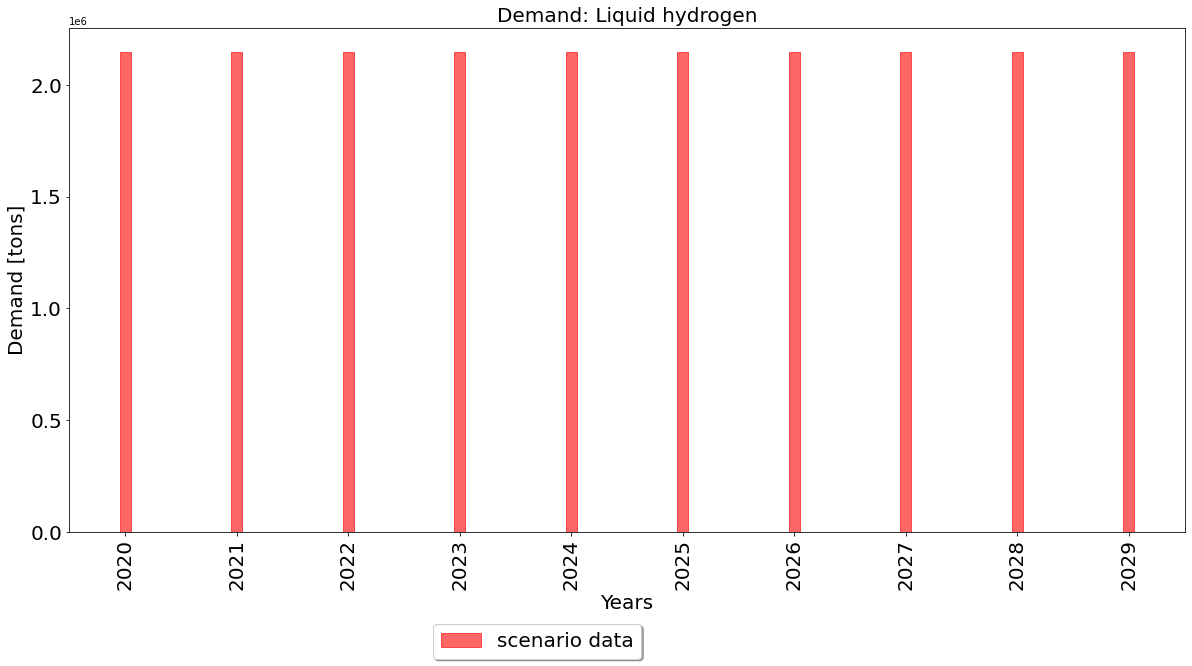

In [16]:
#plot the demand at the export terminal over the years 
if carrier == 'liquid hydrogen':
    lhydrogen.plot_demand()
    
if carrier == 'ammonia':
    ammonia.plot_demand()
    
if carrier == 'MCH':
    MCH.plot_demand()

#### Instantiate the vessels 

In [17]:
Smallhydrogen = Vessel(**smallhydrogen_data)
Largehydrogen = Vessel(**largehydrogen_data)
Smallammonia = Vessel(**smallammonia_data)
Largeammonia = Vessel(**largeammonia_data)
Handysize = Vessel(**handysize_data)
Panamax = Vessel(**panamax_data)
VLCC = Vessel(**vlcc_data)

# vessels variable: contains info on vessels (to be added to Terminal.elements)
vessels = [Smallhydrogen, Largehydrogen, Smallammonia, Largeammonia, Handysize, Panamax, VLCC] 

##### From_site: Instantiate Export Terminal

In [18]:
#define the dwelltime for each carrier 
if carrier == 'MCH':
    dwelltime =45/365
else:
    dwelltime = 30/365
    
# Instantiate OpenTISim Terminal
from_site_terminal = opentisim.liquidbulk.ExportTerminal(
            startyear = None, 
            lifecycle = 1, 
            distance = distancekm, 
            elements = demand + vessels, 
            operational_hours = 16*365,   # example Wijnand
            terminal_supply_chain=sc_export,
            debug=False,
            commodity_type_defaults=commodity_type_defaults,
            storage_type_defaults=storage_type_defaults,
            kendall='E2/E2/n',
            allowable_waiting_service_time_ratio_berth=0.3,
            h2conversion_type_defaults=h2conversion_type_defaults,
            allowable_dwelltime= dwelltime)

from_site_terminal.modelframe = list(range(startyear, startyear + lifecycle))
from_site_terminal.revenues = []
from_site_terminal.demurrage = []

# add an OpenTISim Terminal to the graph
FG.nodes['from_site']['terminal'] = from_site_terminal

##### 1.2.2.3. Add terminal properties at the Import Terminal 

Add terminal properties to the Import Terminal (mid_site). 

##### First the vesselmix and the commodity needs to be defined 

In [19]:
if carrier == 'liquid hydrogen':
    commodity_lhydrogen_data['smallhydrogen_perc'] = 0
    commodity_lhydrogen_data['largehydrogen_perc'] = 100
    commodity_lhydrogen_data['historic_data'] = []
    commodity_lhydrogen_data['scenario_data'] = []
    lhydrogen = Commodity(**commodity_lhydrogen_data)
    lhydrogen.scenario_data = throughput_mid
    demand = [lhydrogen] 
    
if carrier == 'ammonia':
    commodity_ammonia_data["smallammonia_perc"] = 0
    commodity_ammonia_data["largeammonia_perc"] = 100
    commodity_ammonia_data['historic_data'] = []
    commodity_ammonia_data['scenario_data'] = []
    ammonia = Commodity(**commodity_ammonia_data)
    ammonia.scenario_data = throughput_mid  #choose what carrier
    demand = [ammonia] 

if carrier == 'MCH':
    commodity_MCH_data["handysize_perc"] = 0
    commodity_MCH_data["panamax_perc"] = 0
    commodity_MCH_data["vlcc_perc"] = 100
    commodity_MCH_data['historic_data'] = []
    commodity_MCH_data['scenario_data'] = []
    MCH = Commodity(**commodity_MCH_data)
    MCH.scenario_data = throughput_mid  #choose what carrier
    demand = [MCH] 



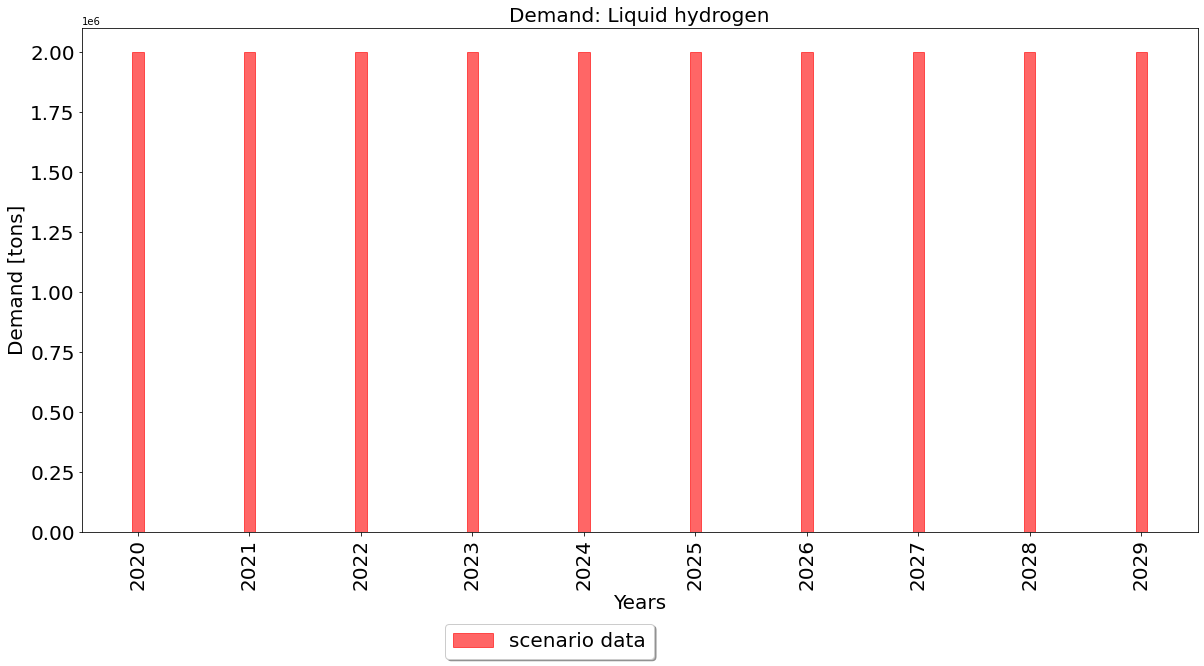

In [20]:
#plot the demand at the export terminal over the years
if carrier == 'liquid hydrogen':
    lhydrogen.plot_demand()
    
if carrier == 'ammonia':
    ammonia.plot_demand()
    
if carrier == 'MCH':
    MCH.plot_demand()

##### Instantiate vessels

In [21]:
Smallhydrogen = Vessel(**smallhydrogen_data)
Largehydrogen = Vessel(**largehydrogen_data)
Smallammonia = Vessel(**smallammonia_data)
Largeammonia = Vessel(**largeammonia_data)
Handysize = Vessel(**handysize_data)
Panamax = Vessel(**panamax_data)
VLCC = Vessel(**vlcc_data)

# vessels variable: contains info on vessels (to be added to Terminal.elements)
vessels = [Smallhydrogen, Largehydrogen, Smallammonia, Largeammonia, Handysize, Panamax, VLCC] 

##### Mid_site: Instantiate Import Terminal

In [22]:
#define the dwelltime for each carrier
if carrier == 'MCH':
    dwelltime = 45/365
else:
    dwelltime = 30/365

# Instantiate OpenTISim Terminal
mid_site_terminal =  opentisim.liquidbulk.System(
            startyear = None, 
            lifecycle = 1, 
            elements = demand + vessels, 
            operational_hours = 16*365,   # example Wijnand
            terminal_supply_chain=sc_import,
            debug=False,
            commodity_type_defaults=commodity_type_defaults,
            storage_type_defaults=storage_type_defaults,
            kendall='E2/E2/n',
            allowable_waiting_service_time_ratio_berth=0.3,
            h2retrieval_type_defaults=h2retrieval_type_defaults,
            allowable_dwelltime= dwelltime)


mid_site_terminal.modelframe = list(range(startyear, startyear + lifecycle))
mid_site_terminal.revenues = []
mid_site_terminal.demurrage = []

# add an OpenTISim Terminal to the graph
FG.nodes['mid_site']['terminal'] = mid_site_terminal

#### 1.2.3 Identify active supply chains

Identify the active supply chains. In this example there is one supply chain from the export terminal (from_site), to the import terminal (mid_site). When the simulation starts there is no throughput yet. 

In [23]:
supplychain_1 = SupplyChain(
    name='Supplychain 1',
    elements = [],
    origin = 'from_site',
    origin_latent_demand = 0,
    origin_online_throughput = 0,
    destination='mid_site',
    destination_latent_demand = 0,
    destination_online_throughput = 0,
    condition=[{"type": "container", "concept": 'from_site', "state": "empty"}],
    capacity=None)

In [24]:
supplychains = [supplychain_1]

## 2. Run Terminals and Transport

Now it is time to simulate the supply chain. First the terminals have to be simulated to know what the throughput is each year. Second the transport of each year is simulated by taking the throughput of each year. First of all the ship characteristics have to be defined, depending on the type of carrier. 

#### Find ship characteristics

In [25]:
capacity_ship = vessel_defaults["call_size"]
pump_ship = vessel_defaults["pump_capacity"]
loadingtime_ship = ((vessel_defaults["call_size"]/vessel_defaults["pump_capacity"]) +vessel_defaults["mooring_time"])*60*60
unloadingtime_ship = ((vessel_defaults["call_size"]/vessel_defaults["pump_capacity"]) +vessel_defaults["mooring_time"])*60*60
velocity_ship = vessel_defaults['avspeed']/3.6 # #25 km/h --> m/s 
losses_ship = vessel_defaults['losses']

if carrier == 'MCH':
    loadingtime_ship = 2*loadingtime_ship
    unloadingtime_ship = 2*unloadingtime_ship

Secondly the simulation has to start. With the 'Debug' and 'debug' function you can decide what will be printed. Furthermore, some empty dataframes need to be created and some arrays need to be defined. After this the simulation can begin for the terminals and transport. The terminals and transport will be simulated for every year that is defined with the startyear and modellife by looping through the years. The simulation also loops through the defined supply chains. In this example only one supply chain is defined (export - import), however one can define a second supply chain (e.g. export - import - hinterland) in which the terminal elements and transport can also be simulated.   

#### Run simulation 

In [26]:
#decide what will be printed 
Debug = False
debug = True

#create empty dataframes 
commodity_lhydrogen_data['scenario_data'] = []
commodity_ammonia_data['scenario_data'] = []
commodity_MCH_data['scenario_data'] = []
dataframe_openclsim = []

#define arrays 
years = list(range(startyear, startyear+lifecycle))
years1 =  list(range(startyear, startyear+lifecycle))
years2 = list(range(startyear+2,startyear+lifecycle))


#simulate the terminals and the transport 
#the simulation loops through the modellife 
for index_year,year in enumerate(years):
    # OpenTISim: op 1 januari neem je al je beslissingen (terminals + supply chains)
    if debug == True:
        print('')
        print('simulation for year: {} ---------------'.format(year))
    
    #run through the defined supply chains 
    for supplychain in supplychains:
        count_vessel = 0 
        FG.nodes[supplychain.origin]['site'] = []
        FG.nodes[supplychain.destination]['site'] = []
        # 1. if the throughput in the origin > 0, run the terminal and define the elements 
        throughput_online_origin = 0
        if type(FG.nodes[supplychain.origin]['througput']) == pd.core.frame.DataFrame:
            FG.nodes[supplychain.origin]['terminal'].startyear = year
            FG.nodes[supplychain.origin]['terminal'].debug = Debug
            FG.nodes[supplychain.origin]['terminal'].simulate()
            
            throughput_online_origin, throughput_terminal_in,throughput_online_jetty_in, throughput_online_stor_in, throughput_online_plant_in, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  =  FG.nodes[supplychain.origin]['terminal'].throughput_elements(year)
    
            if debug == True:
                print('Terminal: {}, year: {}, throughput online: {}'.format(supplychain.origin, year, throughput_online_origin))
                print('')
                print()

            supplychain.origin_online_throughput = throughput_online_origin
            
        # 2. if the throughput in the desintation > 0, run the terminal and define the elements 
        throughput_online_destination = 0
        if type(FG.nodes[supplychain.destination]['througput']) == pd.core.frame.DataFrame:
            
            FG.nodes[supplychain.destination]['terminal'].startyear = year
            FG.nodes[supplychain.destination]['terminal'].debug = Debug
            FG.nodes[supplychain.destination]['terminal'].simulate()
            
            throughput_online_destination, throughput_terminal_in,throughput_online_jetty_in_dest, throughput_online_stor_in, throughput_online_plant_in, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  = FG.nodes[supplychain.destination]['terminal'].throughput_elements(year)
            
            if debug == True:
                print('Terminal: {}, year: {}, throughput: {}'.format(supplychain.destination, year, throughput_online_destination))
                print('')
            
            supplychain.destination_online_throughput = throughput_online_jetty_in_dest
            
        # 3. if the origin has a throughput and the destination does not have a throughput, add a throughput to the destination 
        if throughput_online_origin != 0 and throughput_online_destination == 0:
            if debug == True:
                print('The origin is generating throughput. I need a latent demand in the destination location.')

            supplychain.destination_latent_demand = throughput_online_origin

            # Use the throughput at the other end of the supply chain as a latent demand

            # Liquid hydrogen
            if carrier == 'liquid hydrogen':
                commodity_lhydrogen_data['historic_data'] = []
                lhydrogen = Commodity(**commodity_lhydrogen_data)
                lhydrogen.scenario_data.append({'year': year, 'volume': throughput_online_jetty_origin})
                lhydrogen.scenario_data = pd.DataFrame(lhydrogen.scenario_data)
                demand = [lhydrogen]
            

            # Ammonia
            if carrier == 'ammonia':
                commodity_ammonia_data['historic_data'] = []
                ammonia = Commodity(**commodity_ammonia_data)
                ammonia.scenario_data.append({'year': year, 'volume': throughput_online_jetty_origin})
                ammonia.scenario_data = pd.DataFrame(ammonia.scenario_data)
                demand = [ammonia]

            # MCH
            if carrier == 'MCH': 
                commodity_MCH_data['historic_data'] = []
                MCH = Commodity(**commodity_MCH_data)
                MCH.scenario_data.append({'year': year, 'volume': throughput_online_jetty_origin})
                MCH.scenario_data = pd.DataFrame(MCH.scenario_data)
                demand = [MCH]

            
            # adopt vessels from the other node
            vessels = [x for x in FG.nodes[supplychain.origin]['terminal'].elements if type(x) == Vessel]
            
            # find all terminal_elements that are NOT a commodity
            terminal_elements = [x for x in FG.nodes[supplychain.destination]['terminal'].elements if type(x) != Commodity and type(x) != Vessel]

            # add terminal_elements + new demands
            FG.nodes[supplychain.destination]['terminal'].elements = terminal_elements + demand + vessels          
            FG.nodes[supplychain.destination]['terminal'].startyear = year
            FG.nodes[supplychain.destination]['terminal'].debug = Debug
            FG.nodes[supplychain.destination]['terminal'].years = years2
            FG.nodes[supplychain.destination]['terminal'].simulate()

            throughput_online_destination, throughput_terminal_in,throughput_online_jetty_in_dest, throughput_online_stor_in, throughput_online_plant_in, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  =  FG.nodes[supplychain.destination]['terminal'].throughput_elements(year)
            
            if debug == True:
                print('Terminal: {}, year: {}, throughput: {}'.format(supplychain.destination, year, throughput_online_jetty_destination))
                print('')
            
            supplychain.destination_online_throughput = throughput_online_jetty_in_dest
            
        # 4. if the destination has a throughput and the origin does not have a throughput, add a throughput to the origin 
        if throughput_online_origin == 0 and throughput_online_destination != 0:
            if debug == True:
                print('The destination is generating throughput. I need latent demand in the origin location')
            
            supplychain.origin_latent_demand = throughput_online_jetty_in_dest

            # Use the throughput at the other end of the supply chain as a latent demand
            supply = list(np.matlib.repmat(throughput_online_jetty_destination,1,1)[0])
            througput_origin = pd.DataFrame({'year': year, 'volume': supply})

            # Liquid hydrogen
            if carrier == 'liquid hydrogen':
                commodity_lhydrogen_data['historic_data'] = []

                if lhydrogen.scenario_data['volume'].values[-1] > throughput_online_jetty_destination:
                    lhydrogen.scenario_data = lhydrogen.scenario_data
                    #print('true')
                else:
                    lhydrogen.scenario_data.append({'year': year, 'volume': throughput_online_jetty_destination}) #xxx
                    lhydrogen.scenario_data = pd.DataFrame(lhydrogen.scenario_data)
                    #print('false')
                demand = [lhydrogen]
            
            if carrier == 'ammonia':
                commodity_ammonia_data['historic_data'] = []
                if ammonia.scenario_data['volume'].values[-1] > throughput_online_jetty_destination:
                    ammonia.scenario_data = ammonia.scenario_data
                    #print('true')
                else:
                    ammonia.scenario_data.append({'year': year, 'volume': throughput_online_jetty_destination}) #xxx
                    ammonia.scenario_data = pd.DataFrame(ammonia.scenario_data)
                    #print('false')
                demand = [ammonia]
            
            if carrier == 'MCH':
                commodity_MCH_data['historic_data'] = []
                if MCH.scenario_data['volume'].values[-1] > throughput_online_jetty_destination:
                    MCH.scenario_data = MCH.scenario_data
                    #print('true')
                else:
                    MCH.scenario_data.append({'year': year, 'volume': throughput_online_jetty_destination}) #xxx
                    MCH.scenario_data = pd.DataFrame(MCH.scenario_data)
                    #print('false')
                demand = [MCH]
                    
            
            # adopt vessels from the other node
            vessels = [x for x in FG.nodes[supplychain.destination]['terminal'].elements if type(x) == Vessel]
            
            # find all terminal_elements that are NOT a commodity
            terminal_elements = [x for x in FG.nodes[supplychain.origin]['terminal'].elements if type(x) != Commodity and type(x) != Vessel]

            # add terminal_elements + new demands
            FG.nodes[supplychain.origin]['terminal'].elements = terminal_elements + demand + vessels
            FG.nodes[supplychain.origin]['terminal'].startyear = year
            FG.nodes[supplychain.origin]['terminal'].debug = Debug
            FG.nodes[supplychain.origin]['terminal'].years = years2
            FG.nodes[supplychain.origin]['terminal'].simulate()

            throughput_online_origin, throughput_terminal_in,throughput_online_jetty_in, throughput_online_stor_in, throughput_online_plant_in, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  = FG.nodes[supplychain.origin]['terminal'].throughput_elements(year)
            
            if debug == True:
                print('Terminal: {}, year: {}, throughput: {}'.format(supplychain.origin, year, throughput_online_jetty_origin))
                print('')

            supplychain.origin_online_throughput = throughput_online_origin
    
    # 5. Run openCLSim calculation
    # OpenCLSim: tussen 2 januari - 31 december ga je transporteren
    # first check if there is throughput in both the origin and destination
    if supplychain.origin_online_throughput !=0 and supplychain.destination_online_throughput!=0:
        # step past all supplychains to initiate the sites and vessels
        for index, supplychain in enumerate(supplychains):
            # when the index = 0, the transport in the first supply chain is simulated
            if index == 0:
                level_from_site = supplychain.origin_online_throughput
                level_to_site = 0
                # activities = []
                # in the while loop one trip of a vessel is simulated, this takes place again and again untill there is no cargo left at the origin 
                while level_from_site != 0: #transport can only take place if there is cargo at the origin 
                    count_vessel += 1 #count the vessels that are needed to transport all the cargo 
                    if debug == True:
                        print('**Add a ship**')
                    #make environment 
                    simulation_start = 0 
                    my_env = simpy.Environment(initial_time=simulation_start)
                                  
                    # origin
                    capacity_from_site = max([supplychain.origin_online_throughput, supplychain.destination_latent_demand])
                    #level_from_site = min([supplychain.origin_online_throughput, supplychain.destination_latent_demand])
                    data_from_site = {"env": my_env,
                                 "name": supplychain.origin,
                                 "geometry": FG.nodes[supplychain.origin]['geometry'],
                                 "capacity": capacity_from_site, 
                                 "level": level_from_site
                                 }
                    FG.nodes[supplychain.origin]['site'] = Site(**data_from_site)
                    from_site = Site(**data_from_site)
                                       
                    # destination
                    capacity_to_site = capacity_from_site #max([supplychain.destination_online_throughput, supplychain.origin_latent_demand])
                    #level_to_site = min([supplychain.destination_online_throughput, supplychain.origin_latent_demand])
                    data_to_site = {"env": my_env,
                                 "name": supplychain.destination,
                                 "geometry": FG.nodes[supplychain.destination]['geometry'],
                                 "capacity": capacity_to_site, 
                                 "level": level_to_site #0
                                 }
                    FG.nodes[supplychain.destination]['site'] = Site(**data_to_site)
                    to_site = Site(**data_to_site)
                    
                    #prepare input data for the boil off process  
                    capacity_bog = capacity_to_site
                    
                    boil_off_container = {"env": my_env,
                                 "name": 'boil-off',
                                  "geometry": FG.nodes[supplychain.destination]['geometry'],
                                 "capacity": capacity_bog, 
                                  "compute_v": lambda x: 0
                                }

                    # instantiate the boil off process 
                    boil_off01 = BoiloffResource(**boil_off_container)
                    
                    if debug == True:
                        print('capacity at origin', capacity_from_site)
                        print('level at origin', level_from_site)
                        print('capacity at destination', capacity_to_site)
                        print('level at destination', level_to_site)
                    
                    # vessels
                    # prepare input data for vessel_01
                    data_vessel01 = {"env": my_env,
                                     "name": "vessel " + supplychain.name,
                                     "geometry": FG.nodes[supplychain.origin]['geometry'], 
                                     "loading_rate": 0.00001,
                                     "unloading_rate": 0.00001,
                                     "capacity": capacity_ship,
                                     "compute_v": lambda x: velocity_ship
                                    }
                
            
                    # instantiate vessel_01 
                    vessel01 = TransportProcessingResource(**data_vessel01)
                
                    supplychain.elements = [vessel01]

                    # use the sites from the graph and the vessels from the supplychains to construct activities
                    #activities = []

                    # initialise registry
                    registry = {}
                    if debug == True:
                        print('transporter activity between from_site and mid_site')

                    # create a list of the sub processes
                    requested_resources1 = {}
                    # the processes consist of sailing empty, loading, sailing full, boil off, unloading 
                    sub_processes = [
                        openclsim.model.MoveActivity(
                            env=my_env,
                            name="sailing empty",
                            registry=registry,
                            mover=vessel01,
                            destination=from_site,
                            requested_resources=requested_resources1,
                        ),
                        openclsim.model.ShiftAmountActivity(
                            env=my_env,
                            name="loading",
                            registry=registry,
                            processor=vessel01,
                            origin=from_site,
                            destination=vessel01,
                            amount=capacity_ship,
                            duration=loadingtime_ship,
                            requested_resources=requested_resources1,
                        ),
                        openclsim.model.MoveActivity(
                            env=my_env,
                            name="sailing full",
                            registry=registry,
                            mover=vessel01,
                            destination=to_site,
                            requested_resources=requested_resources1,
                        ),
                        openclsim.model.ShiftAmountActivity(
                            env=my_env,
                            name="boil off",
                            registry=registry,
                            processor=vessel01,
                            origin=vessel01,
                            destination=boil_off01,
                            amount=lossofload,
                            duration=0,
                            requested_resources=requested_resources1,
                        ),
                        openclsim.model.ShiftAmountActivity(
                            env=my_env,
                            name="unloading",
                            registry=registry,
                            processor=vessel01,
                            origin=vessel01,
                            destination=to_site,
                            amount=capacity_ship,
                            duration=unloadingtime_ship, #in seconds 
                            requested_resources=requested_resources1,
                        ),
                        openclsim.model.BasicActivity(
                            env=my_env,
                            name="basic activity",
                            registry=registry,
                            duration=0,
                            additional_logs=[vessel01],
                            requested_resources=requested_resources1,
                        ),
                    ]

                    # create a 'sequential activity' that is made up of the 'sub_processes'
                    sequential_activity = openclsim.model.SequentialActivity(
                        env=my_env,
                        name="sequential_activity_subcycle_1",
                        registry=registry,
                        sub_processes=sub_processes,
                    )
                    
                    # now the site has been created we can add the site variable to the condition
                    # the condition represents the condition for the openclsim simulation to stop 
                    
                    # if there is still cargo at the from_site, each vessel has the condition that it sails the entire year 
                    if level_from_site > maxtrans1:
                        print('yes')
                        condition = [{"type": "activity", "name": "while_sequential_activity_subcycle ", "state": "done"}]
                        
                        while_activity = openclsim.model.WhileActivity(
                            env=my_env,
                            name="while_sequential_activity_subcycle ", #+ supplychain.name,
                            registry=registry,
                            sub_processes=[sequential_activity],
                            condition_event=condition,
                        )
                        
                        model.register_processes([while_activity])
                        secyear = 60*60*24*365
                        my_env.run(until = secyear)
                    # if the cargo that is present at the from_site is less than one ship can carry maximum in a year, 
                    # the condition changes; the last vessels needs to sail untill the from_site is empty 
                    else:
                        print('no')
                        condition1 = [{"type": "container", "concept": from_site, "state": "empty"}]
                        sub_processes_new = sub_processes.pop(3)
                        
                        sequential_activity = openclsim.model.SequentialActivity(
                            env=my_env,
                            name="sequential_activity_subcycle_1",
                            registry=registry,
                            sub_processes=sub_processes,
                        )
                    
                        
                        while_activity = openclsim.model.WhileActivity(
                            env=my_env,
                            name="while_sequential_activity_subcycle ", #+ supplychain.name,
                            registry=registry,
                            sub_processes=[sequential_activity],
                            condition_event=condition1,
                        )
                        
                        model.register_processes([while_activity])
                        my_env.run()
                        
                    #now that the vessels are simulated by openclsim the level_from_site needs to become less and the level_to_site is filling up
                    #the new levels after each transport cycle need to be defined
                    #the new levels have to take into account that cargo is lossed during sailing due to boil off 

                    df1 = plot.get_log_dataframe(from_site, [while_activity, *sub_processes])
                    level_from_site = df1['container level'].values[-1]
                    
                    df2 = plot.get_log_dataframe(to_site, [while_activity, *sub_processes])
                    level_to_site = df2['container level'].values[-1]
                    
                    df4 = plot.get_log_dataframe(vessel01, [while_activity, *sub_processes])
                    
                    # if the ship is constantly full during the year, the boil off losses are the same for each trip 
                    if level_from_site > maxtrans1:
                        df3 = plot.get_log_dataframe(boil_off01, [while_activity, *sub_processes])
                        
                        if df4['container level'].values[-1] != 0:
                            level_boil_off = df3['container level'].values[-1] + lossofload 
                        else: 
                            level_boil_off = df3['container level'].values[-1] 

                        level_vessel = df4['container level'].values[-1]
                        
                    # define the new level at the destination by taking into account the boil off losses 
                    if df4['container level'].values[-1] != 0:
                        new = df2['container level'].values[-1] + (df4['container level'].values[-1]-lossofload)
                    else: 
                        new = df2['container level'].values[-1] + df4['container level'].values[-1]

                    level_to_site = new

                    if debug == True:
                                print(
                                    '     a total of {} ton of hydrogen is at the origin'.format(
                                        level_from_site))
                                
#                                 print(
#                                     '     a total of {} ton of hydrogen is at boil-off'.format(
#                                         level_boil_off ))
#                                 print(
#                                     '     a total of {} ton of hydrogen is at vessel'.format(
#                                         level_vessel ))
                                print(
                                    '     a total of {} ton of hydrogen is at the destination when last vessel is emptied'.format(
                                        level_to_site))
                                
                # add the data to the dataframe of openclsim 
                dataframe_openclsim.append({'year': year,'level to site': level_to_site, 'vessel count':count_vessel,})
       


simulation for year: 2020 ---------------
Terminal: from_site, year: 2020, throughput online: 0.0


Terminal: mid_site, year: 2020, throughput: 0.0


simulation for year: 2021 ---------------
Terminal: from_site, year: 2021, throughput online: 0.0


Terminal: mid_site, year: 2021, throughput: 0.0


simulation for year: 2022 ---------------
Terminal: from_site, year: 2022, throughput online: 2146973.703699869


Terminal: mid_site, year: 2022, throughput: 2000000.0

**Add a ship**
capacity at origin 2146973.703699869
level at origin 2146973.703699869
capacity at destination 2146973.703699869
level at destination 0
transporter activity between from_site and mid_site
yes
     a total of 1958113.703699869 ton of hydrogen is at the origin
     a total of 178380.75315962138 ton of hydrogen is at the destination when last vessel is emptied
**Add a ship**
capacity at origin 2146973.703699869
level at origin 1958113.703699869
capacity at destination 2146973.703699869
level at destination 178380

     a total of 69513.7036998691 ton of hydrogen is at the origin
     a total of 1962188.2847558307 ton of hydrogen is at the destination when last vessel is emptied
**Add a ship**
capacity at origin 2146973.703699869
level at origin 69513.7036998691
capacity at destination 2146973.703699869
level at destination 1962188.2847558307
transporter activity between from_site and mid_site
no
     a total of 0.0 ton of hydrogen is at the origin
     a total of 2031701.9884556998 ton of hydrogen is at the destination when last vessel is emptied

simulation for year: 2024 ---------------
Terminal: from_site, year: 2024, throughput online: 2146973.703699869


Terminal: mid_site, year: 2024, throughput: 2000000.0

**Add a ship**
capacity at origin 2146973.703699869
level at origin 2146973.703699869
capacity at destination 2146973.703699869
level at destination 0
transporter activity between from_site and mid_site
yes
     a total of 1958113.703699869 ton of hydrogen is at the origin
     a total 

     a total of 258373.7036998691 ton of hydrogen is at the origin
     a total of 1783807.5315962099 ton of hydrogen is at the destination when last vessel is emptied
**Add a ship**
capacity at origin 2146973.703699869
level at origin 258373.7036998691
capacity at destination 2146973.703699869
level at destination 1783807.5315962099
transporter activity between from_site and mid_site
yes
     a total of 69513.7036998691 ton of hydrogen is at the origin
     a total of 1962188.2847558307 ton of hydrogen is at the destination when last vessel is emptied
**Add a ship**
capacity at origin 2146973.703699869
level at origin 69513.7036998691
capacity at destination 2146973.703699869
level at destination 1962188.2847558307
transporter activity between from_site and mid_site
no
     a total of 0.0 ton of hydrogen is at the origin
     a total of 2031701.9884556998 ton of hydrogen is at the destination when last vessel is emptied

simulation for year: 2026 ---------------
Terminal: from_site, y

     a total of 824953.7036998691 ton of hydrogen is at the origin
     a total of 1248665.2721173475 ton of hydrogen is at the destination when last vessel is emptied
**Add a ship**
capacity at origin 2146973.703699869
level at origin 824953.7036998691
capacity at destination 2146973.703699869
level at destination 1248665.2721173475
transporter activity between from_site and mid_site
yes
     a total of 636093.7036998691 ton of hydrogen is at the origin
     a total of 1427046.0252769683 ton of hydrogen is at the destination when last vessel is emptied
**Add a ship**
capacity at origin 2146973.703699869
level at origin 636093.7036998691
capacity at destination 2146973.703699869
level at destination 1427046.0252769683
transporter activity between from_site and mid_site
yes
     a total of 447233.7036998691 ton of hydrogen is at the origin
     a total of 1605426.778436589 ton of hydrogen is at the destination when last vessel is emptied
**Add a ship**
capacity at origin 2146973.7036998

     a total of 1391533.703699869 ton of hydrogen is at the origin
     a total of 713523.0126384851 ton of hydrogen is at the destination when last vessel is emptied
**Add a ship**
capacity at origin 2146973.703699869
level at origin 1391533.703699869
capacity at destination 2146973.703699869
level at destination 713523.0126384851
transporter activity between from_site and mid_site
yes
     a total of 1202673.703699869 ton of hydrogen is at the origin
     a total of 891903.7657981059 ton of hydrogen is at the destination when last vessel is emptied
**Add a ship**
capacity at origin 2146973.703699869
level at origin 1202673.703699869
capacity at destination 2146973.703699869
level at destination 891903.7657981059
transporter activity between from_site and mid_site
yes
     a total of 1013813.7036998691 ton of hydrogen is at the origin
     a total of 1070284.5189577267 ton of hydrogen is at the destination when last vessel is emptied
**Add a ship**
capacity at origin 2146973.703699869

## 3. Present Results

Now that the simulation has run it is time to plot the results. For each terminal one can plot how many elements are present at the terminal each year, furthermore one can also plot what the CAPEX and OPEX is for each terminal each year. The same can be done for the transport. First the data frame of openclsim needs to be defined.

##### Define dataframe openCLSim loop

In [27]:
df_openclsim = pd.DataFrame(dataframe_openclsim)

Now we can show all the elements that are present at each terminal 

### Import Terminal 

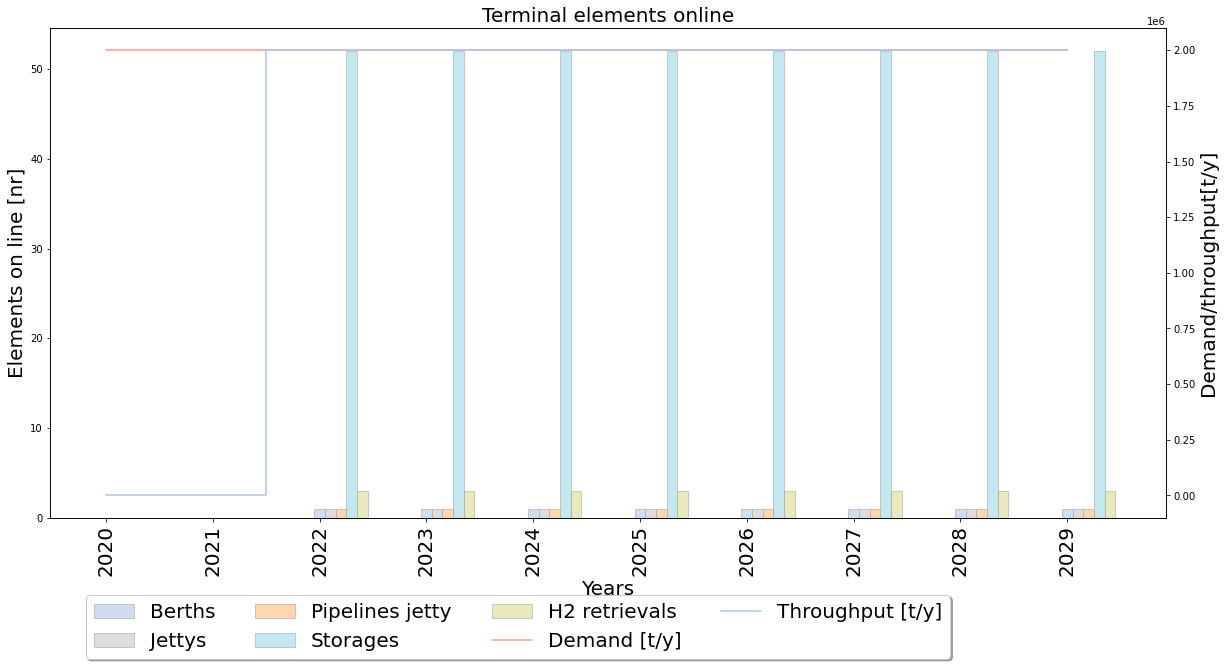

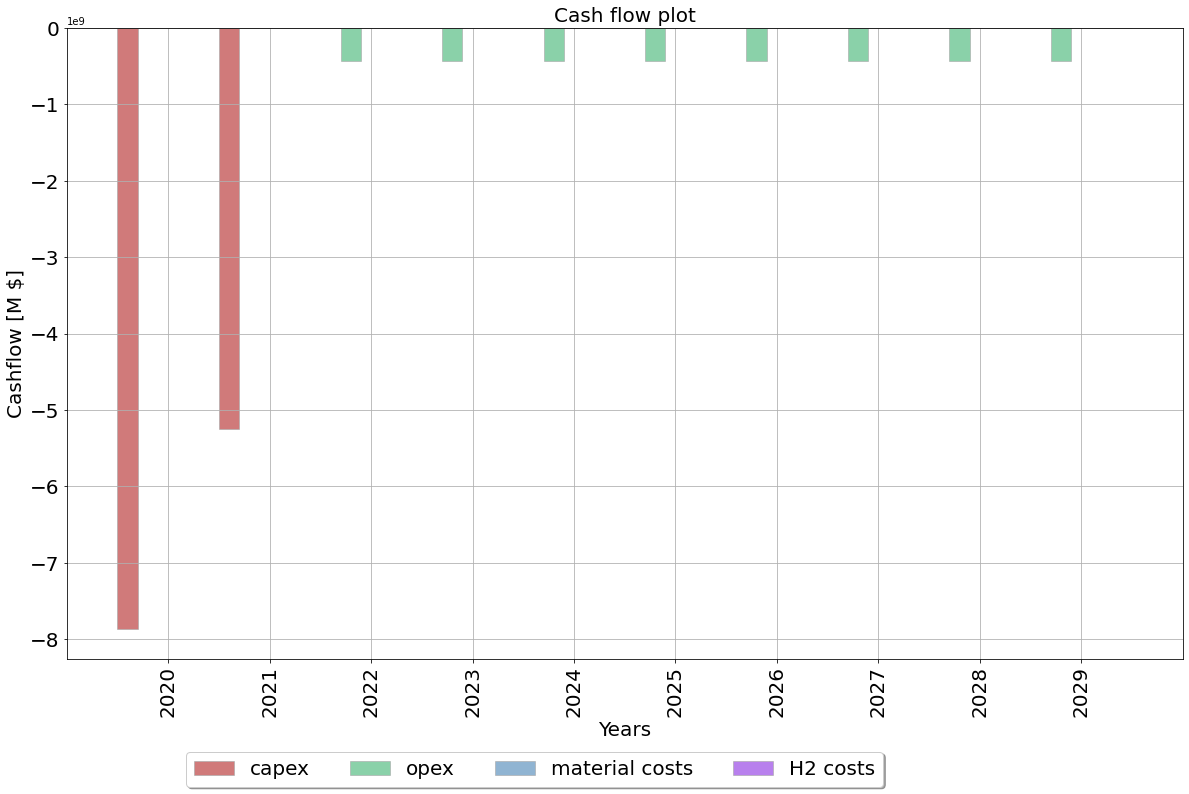

In [36]:
#define the terminal 
node = 'mid_site'
FG.nodes[node]['terminal'].years = years
self = FG.nodes[node]['terminal']

#plot the terminal elements over time 
self.terminal_elements_plot() #jetty

#plot the CAPEX and OPEX over time 
labour = Labour(**labour_data)
cash_flows_importterminal, cash_flows_WACC_real_importterminal = opentisim.core.add_cashflow_elements(self, labour)
opentisim.plot.cashflow_plot(self, cash_flows_importterminal)

### Export Terminal 

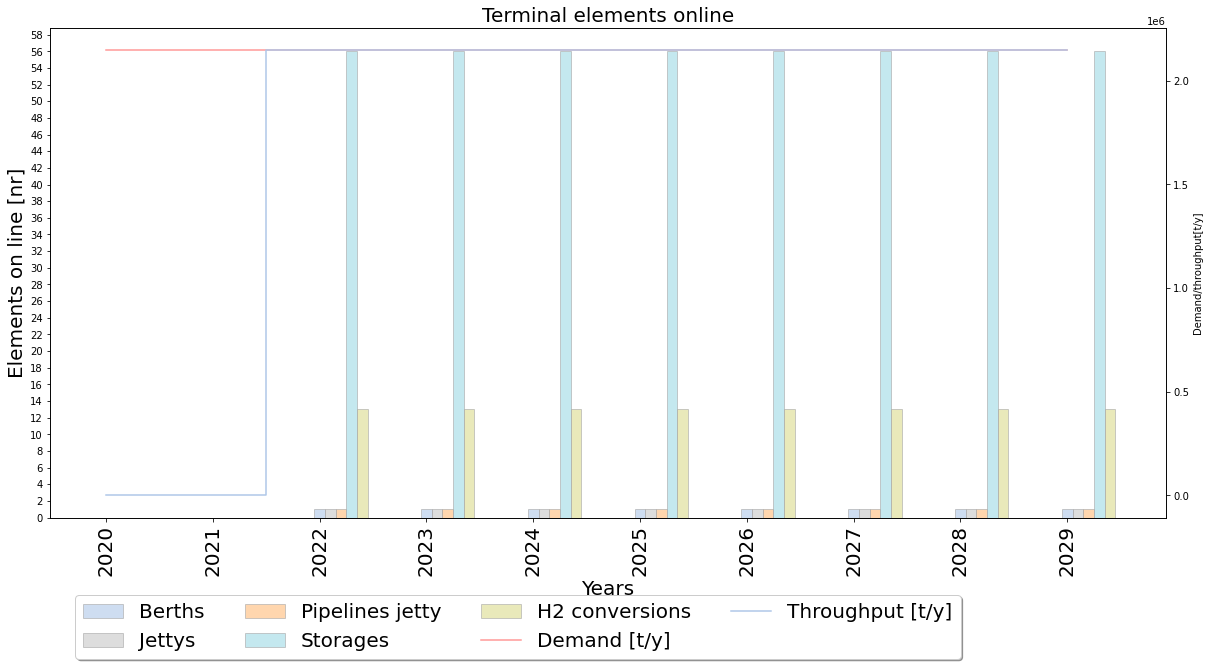

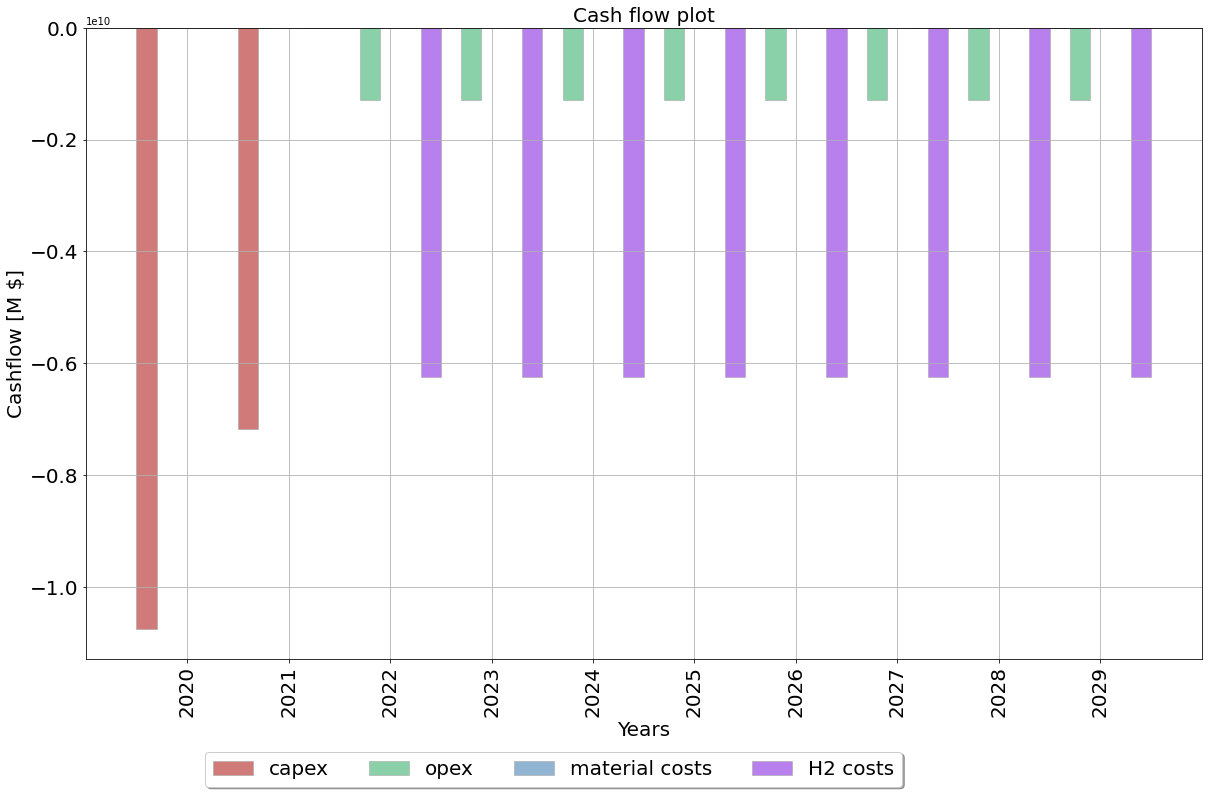

In [37]:
#define the terminal 
node = 'from_site'
FG.nodes[node]['terminal'].years = years
self = FG.nodes[node]['terminal']

#plot the terminal elements over time 
self.terminal_elements_plot() 

#plot the CAPEX and OPEX over time 
labour = Labour(**labour_data)
cash_flows_exportterminal, cash_flows_WACC_real_exportterminal = opentisim.core.add_cashflow_elements(self, labour)
opentisim.plot.cashflow_plot(self, cash_flows_exportterminal)

### Transport 

In [31]:
#import transport_plots
from opentisim.liquidbulk.transport_plots import *

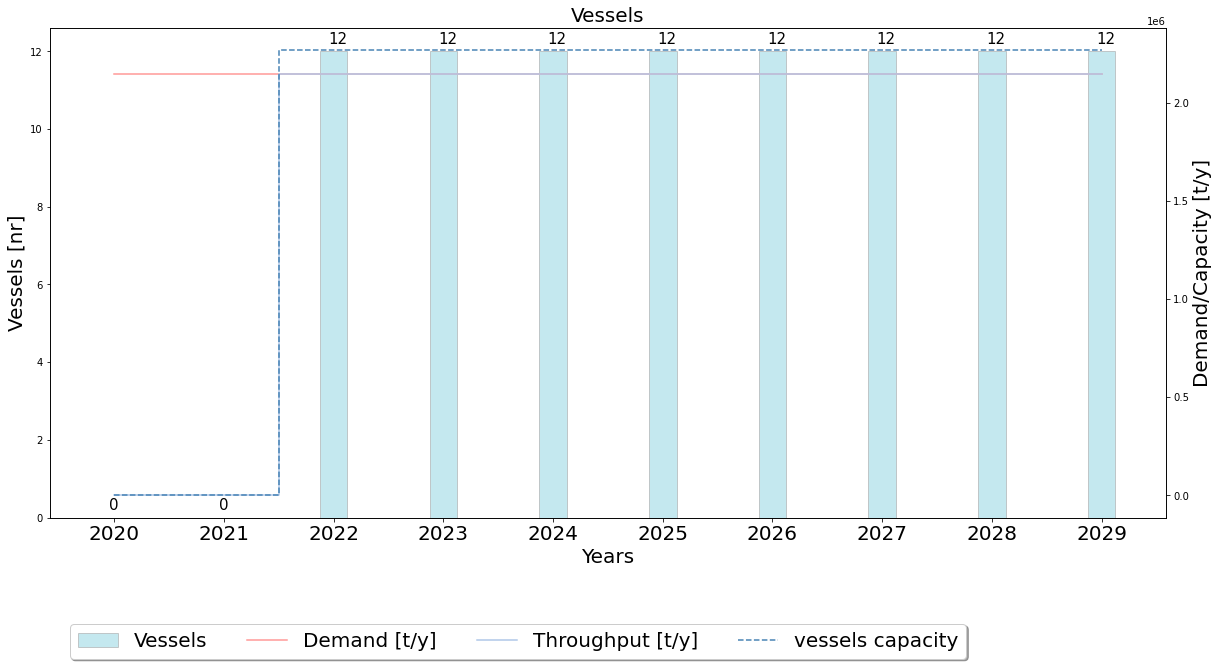

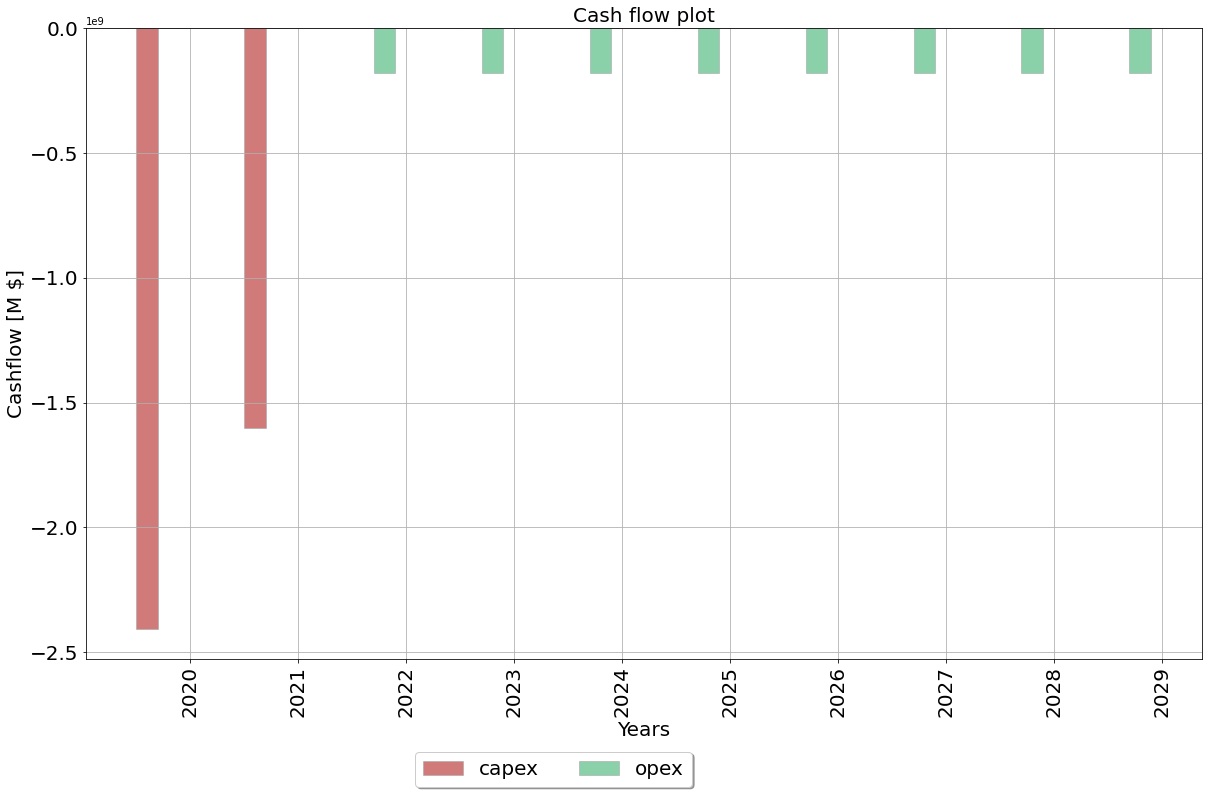

In [38]:
#define the export terminal 
node = 'from_site'
FG.nodes[node]['terminal'].years = years
terminal = FG.nodes[node]['terminal']

#define the openclsim data frame 
dataframe_vessel = df_openclsim

#plot the transport elements over time 
seaborne_transport = vessel_objects(terminal, dataframe_vessel, vessel_defaults, durationdays, numberoftrips)
transport_elements_plot(terminal, seaborne_transport, numberoftrips, width=0.25, alpha=0.6)

#plot the CAPEX and OPEX over time 
cash_flows_seatransport,cash_flows_WACC_real_seatransport = add_cashflow_vessels(terminal, seaborne_transport)
cashflow_plot(cash_flows_seatransport, title='Cash flow plot', width=0.2, alpha=0.6, fontsize=20)

### Total Cost Price

What is also interesting is to calculate the total cost price of a specific supply chain. The total cost price should be calculated in €/ kg H2, to compare the total cost price of all the different forms of hydrogen transport carriers. This is done by adding up all the costs over the years for the import terminal, export terminal and the transport. These are are then divided by the total throughput over all the years that comes out of the import terminal.   

In [33]:
def costprice_supplychain1(years,Hcontent, cash_flows_importterminal, cash_flows_exportterminal, cash_flows_seatransport):
    # calculate the total throughput out of the import terminal over the years in H2 
    throughputsum = 0 
    for year in years:
        throughput_online_des, throughput_terminal_in_des ,throughput_online_jetty_in_des, throughput_online_stor_in_des, throughput_online_plant_in_des, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  =  FG.nodes[supplychain.destination]['terminal'].throughput_elements(year)
        throughputsum += throughput_online_des

    throughputsum_kg = throughputsum*1000
    throughputsum_kg_H2 = (throughputsum_kg *Hcontent)/100

    # calculate the total CAPEX 
    capex_import = cash_flows_importterminal['capex']+cash_flows_importterminal['capex_material']
    capex_export = cash_flows_exportterminal['capex']+cash_flows_exportterminal['capex_material']
    capex_transport = cash_flows_seatransport['capex'] 

    capex_tot =  capex_import + capex_export + capex_transport

    # calculate the total OPEX 
    opex_import = cash_flows_importterminal['maintenance']+cash_flows_importterminal['insurance'] + cash_flows_importterminal['energy']+ \
                cash_flows_importterminal['labour'] + cash_flows_importterminal['fuel']+cash_flows_importterminal['purchaseH2']+\
                cash_flows_importterminal['purchase_material']

    opex_export = cash_flows_exportterminal['maintenance']+cash_flows_exportterminal['insurance'] + cash_flows_exportterminal['energy']+ \
                cash_flows_exportterminal['labour'] + cash_flows_exportterminal['fuel']+cash_flows_exportterminal['purchaseH2']+\
                cash_flows_exportterminal['purchase_material']

    opex_transport = cash_flows_seatransport['maintenance']+cash_flows_seatransport['insurance'] + \
                cash_flows_seatransport['labour'] + cash_flows_seatransport['fuel']

    opex_tot = opex_import + opex_export + opex_transport 

    #calculate the total costs over all the years
    costs_tot = capex_tot + opex_tot 
    sum_costs_tot = sum(costs_tot)

    #calculate the total costprice 
    costprice_kgH2 = sum_costs_tot / throughputsum_kg_H2

    #calculate the costprice of each contribution, to compare 
    costprice_import = sum(capex_import+opex_import)/ throughputsum_kg_H2
    costprice_transport = sum(capex_transport+opex_transport)/ throughputsum_kg_H2
    costprice_export = sum(capex_export+opex_export)/ throughputsum_kg_H2

    return(costprice_kgH2,costprice_import, costprice_transport,costprice_export)

In [34]:
#calculate the NPV costprice 
costprice_kgH2_WACC,costprice_import_WACC, costprice_transport_WACC,costprice_export_WACC = costprice_supplychain1(years,Hcontent, cash_flows_WACC_real_importterminal,cash_flows_WACC_real_exportterminal,cash_flows_WACC_real_seatransport)
#calculate the costprice 
costprice_kgH2,costprice_import, costprice_transport,costprice_export = costprice_supplychain1(years,Hcontent, cash_flows_importterminal,cash_flows_exportterminal,cash_flows_seatransport)

print('total cost price of supply chain without WACC is', costprice_kgH2, '€/kgH2')
print('total cost price of supply chain with WACC is', costprice_kgH2_WACC, '€/kgH2')
# print('total cost price of import terminal is', costprice_import_WACC, '€/kgH2')
# print('total cost price of transport is', costprice_transport_WACC, '€/kgH2')
# print('total cost price of export terminal is', costprice_export_WACC, '€/kgH2')

total cost price of supply chain without WACC is 6.264991375953286 €/kgH2
total cost price of supply chain with WACC is 4.47715137285023 €/kgH2
